In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import csv
import sentencepiece as spm

%matplotlib inline

# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

- [네이버 영화리뷰 데이터](https://github.com/e9t/nsmc/)

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?	코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?	SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?	SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

```bash
git clone https://github.com/e9t/nsmc.git
```

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [3]:
import pandas as pd

In [4]:
path_to_nsmc = '/aiffel/nsmc/'

In [5]:
os.listdir(path_to_nsmc)

['.git',
 'raw',
 'code',
 'ratings.txt',
 'ratings_test.txt',
 'synopses.json',
 'ratings_train.txt',
 'README.md']

In [6]:
path_to_nsmc + 'ratings_train.txt'

'/aiffel/nsmc/ratings_train.txt'

In [7]:
ratings_train = pd.read_csv(path_to_nsmc + 'ratings_train.txt', sep = '\t')

In [8]:
ratings_train.shape

(150000, 3)

In [9]:
ratings_train.columns

Index(['id', 'document', 'label'], dtype='object')

In [10]:
ratings_test = pd.read_csv(path_to_nsmc + 'ratings_test.txt', sep = '\t')

In [11]:
ratings_test.shape

(50000, 3)

In [12]:
ratings_test.columns

Index(['id', 'document', 'label'], dtype='object')

In [13]:
ratings = [ratings_train, ratings_test]

In [14]:
ratingsdf = pd.concat(ratings)

In [15]:
def preprocessing(df_row):
    """
    Given is a object from one entry in 
    dataframe row. 
    Preprocess that df_row
    Input::
    - df_row: one entry 
    Output::
    - df_row: preprocessed entry
    """
    t = repr(df_row)
    text = [i for i in t]
    final_text = ''.join(text)
    return final_text.replace("'", "")

In [16]:
ratingsdf['text'] = ratingsdf['document'].apply(preprocessing)

In [17]:
ratingsdf['text_len'] = ratingsdf['text'].str.len()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
sns.set_style('darkgrid')

In [20]:
ratingsdf

,id,document,label,text,text_len
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙.. 진짜 짜증나네요 목소리,19
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,너무재밓었다그래서보는것을추천한다,17
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,61
...,...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,41
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,44
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,34
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,46


In [21]:
# drop raw text
ratingsdf = ratingsdf.drop(['document'],
              axis = 1)

<AxesSubplot:xlabel='label', ylabel='text_len'>

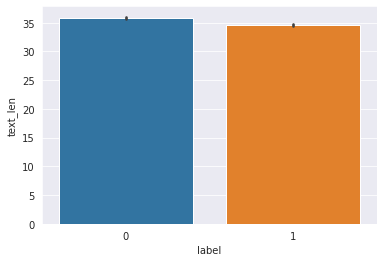

In [22]:
sns.barplot(x = 'label', y = 'text_len',
           data = ratingsdf)

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


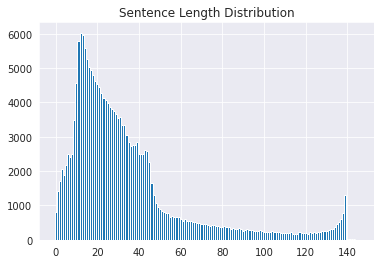

In [23]:
min_len = 999
max_len = 0
sum_len = 0

for sen in ratingsdf['text_len']:
    length = sen
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // ratingsdf.shape[0])

sentence_length = np.zeros((max_len), dtype=int)

for sen in ratingsdf['text_len']:
    sentence_length[sen-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [24]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw = ratingsdf['text'], length = 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [25]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47


Data Size: 194544
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


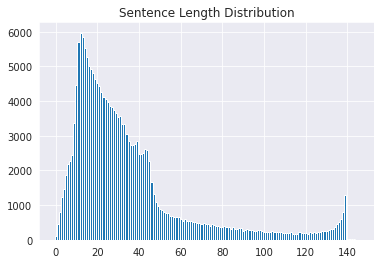

In [26]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(ratingsdf['text']))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

- 중복 제거 후, 평균 길이가 약간 길어졌다

>  길이 10 이하와 길이 140 이상 제거

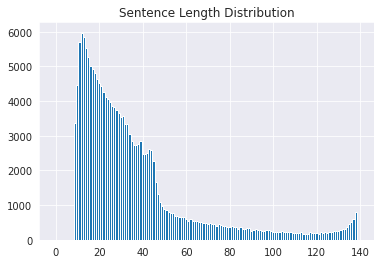

In [27]:
max_len = 140
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [28]:
ratingsdf.shape

(200000, 4)

In [29]:
matched_ind = ratingsdf['text'].isin(filtered_corpus)

In [30]:
matched_ind.value_counts()

True     181100
False     18900
Name: text, dtype: int64

In [32]:
filtered_labels = ratingsdf[matched_ind]['label']

In [33]:
len(filtered_labels)

181100

In [34]:
with open('naver_review_cleaned.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(filtered_corpus))

# Sentencepiece 적용하여 tokenize 하기

- Train the sentencepiece with vocab size of 8000

In [35]:
spm.SentencePieceTrainer.Train('--input=naver_review_cleaned.txt --vocab_size=8000 --model_prefix=naver --model_type=bpe')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=naver_review_cleaned.txt --vocab_size=8000 --model_prefix=naver --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: naver_review_cleaned.txt
  input_format: 
  model_prefix: naver
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eo

bpe_model_trainer.cc(258) LOG(INFO) Added: freq=257 size=2180 all=300655 active=18081 piece=물이
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=255 size=2200 all=301817 active=19243 piece=▁삶을
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=255 min_freq=27
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=253 size=2220 all=302854 active=16125 piece=▁영화중에
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=250 size=2240 all=304308 active=17579 piece=▁성공
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=248 size=2260 all=304917 active=18188 piece=하던
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=246 size=2280 all=305900 active=19171 piece=해주는
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=244 size=2300 all=306908 active=20179 piece=▁얻
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=244 min_freq=27
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=242 size=2320 all=307759 active=16165 piece=▁실패
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=238 size=2340

In [36]:
os.listdir('.')

['naver.vocab',
 'goingdeeper-nlp-quest-final.ipynb',
 'naver.model',
 'goingdeeper-nlp-quest.ipynb',
 'README-Copy1.md',
 'goingdeeper-nlp-node1.ipynb',
 'naver_review_cleaned.txt',
 '.ipynb_checkpoints']

In [37]:
vocab_list = pd.read_csv('naver.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


> spm.SentencePieceProcessor() object 
1. Load model 
2. `obj.encode()` that would output the encoded 
3. `obj.encode_as_ids` that would output the ids

In [38]:
s = spm.SentencePieceProcessor()

In [39]:
s.Load('naver.model')

True

In [40]:
s.encode('안녕하세요') # encoded subject (encode_as_ids default behavior)

[39, 7248, 2400]

In [41]:
tok_hi = s.encode('안녕하세요')

In [42]:
s.encode('안녕하세요', out_type = str) # encoded subject as string

['▁안', '녕', '하세요']

In [43]:
s.encode_as_ids('안녕하세요')

[39, 7248, 2400]

In [44]:
s.decode(tok_hi)

'안녕하세요'

In [53]:
h = ratingsdf[matched_ind]

In [56]:
h

,id,label,text,text_len
0,9976970,0,아 더빙.. 진짜 짜증나네요 목소리,19
1,3819312,1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,33
2,10265843,0,너무재밓었다그래서보는것을추천한다,17
3,9045019,0,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,29
4,6483659,1,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,61
...,...,...,...,...
49995,4608761,1,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,41
49996,5308387,0,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,44
49997,9072549,0,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,34
49998,5802125,0,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,46


In [57]:
def tokenize_sp(s: spm.SentencePieceProcessor, corpus:pd.DataFrame):
    """
    Tokenize the sentencepiece ouput. 
    Use the model and the source dataframe
    """
    tensor = []
    for i,row in corpus.iterrows():
        tensor.append(s.encode(row['text'])) # text column in well-defined dataframe
    word, ind_word = corpus['text'], corpus['id']
    ind_corpus = corpus.index.to_list()
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, ind_word, ind_corpus

In [58]:
tensor, ind_word, ind_corpus = tokenize_sp(s, corpus = ratingsdf[matched_ind])

In [59]:
ind_word.shape

(181100,)

In [60]:
tensor.shape

(181100, 130)

In [61]:
len(ind_corpus)

181100

# Split datasets

In [68]:
from sklearn.model_selection import train_test_split

filtered_labels = np.array(filtered_labels)
X_train, X_test, y_train, y_test = train_test_split(tensor, filtered_labels, test_size=0.2)

# Model
> Will use `Bahdanau Attention` (introduced in https://wikidocs.net/48920)

In [85]:
VOCAB_SIZE = 8000
MAX_LEN = 130

In [69]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
    
    def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [70]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [87]:
sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = Embedding(VOCAB_SIZE, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [88]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

In [89]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)


In [90]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)


(None, 130, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [91]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [92]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [93]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

- Loss: Binary CrossEntropy #binary_ce
- Optimizer: Adam
- Metrics: Accuracy

In [94]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
history = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
566/566 [==============================] - 721s 1s/step - loss: 0.4451 - accuracy: 0.7977 - val_loss: 0.3433 - val_accuracy: 0.8490
Epoch 2/3
566/566 [==============================] - 672s 1s/step - loss: 0.3467 - accuracy: 0.8571 - val_loss: 0.3293 - val_accuracy: 0.8565
Epoch 3/3
566/566 [==============================] - 670s 1s/step - loss: 0.3178 - accuracy: 0.8686 - val_loss: 0.3219 - val_accuracy: 0.8606


In [96]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1132/1132 [==============================] - 56s 50ms/step - loss: 0.3219 - accuracy: 0.8606

 테스트 정확도: 0.8606


# SentencePiece 성능 비교

# 회고록 
- Train이 아예 되질 않았다 
    - vocab_size 를 줄여서 하고, 토큰나이져 function을 조금 변경하였더니 되었다
- Text 전처리 연구를 조금 더 해야하겠다 
- 모델링을 위한 input data 넣는 법 도 공부를 해야하겠다